# Deep Learning for Building Exterior Cladding Classification Using Pre-trained CNNs

readme here

# → Setup (London)(Before Augmentation)

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Details: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPU Details:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Plot visualization parameters

In [4]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Lucida Grande"]
# plt.rcParams['font.size'] = 12  
# plt.rcParams['axes.titlesize'] = 14   
# plt.rcParams['axes.labelsize'] = 12
# plt.rcParams['xtick.labelsize'] = 10
# plt.rcParams['ytick.labelsize'] = 10

plt.style.use('fivethirtyeight')  

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Lucida Grande"],
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.0,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 14,
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.titlepad": 15,
    "axes.labelpad": 10,
    "grid.color": "#e5e5e5"
})
mpl.rcParams['text.usetex'] = False


Paths

In [5]:
base_path_lon = '/Users/meltemsahin/Documents/GitHub/applied-deep-learning/data/exterior_cladding_material/london/before_augmentation'
train_path_lon = os.path.join(base_path_lon, 'train')
val_path_lon = os.path.join(base_path_lon, 'val')
test_path_lon = os.path.join(base_path_lon, 'test')

In [6]:
# parameters
BATCH_SIZE = 32
IMG_SIZE_RES = (224, 224)

In [7]:
# load datasets
train_ds_res = tf.keras.utils.image_dataset_from_directory(
    train_path_lon,
    image_size=IMG_SIZE_RES,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds_res = tf.keras.utils.image_dataset_from_directory(
    val_path_lon,
    image_size=IMG_SIZE_RES,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Get class names
class_names = train_ds_res.class_names
print("Classes:", class_names)

Found 928 files belonging to 6 classes.
Found 308 files belonging to 6 classes.
Classes: ['Brick', 'Concrete', 'Curtain-Wall', 'Mixed', 'Others', 'Stone']


2025-04-13 14:14:41.698419: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-13 14:14:41.698472: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-13 14:14:41.698478: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-13 14:14:41.698519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-13 14:14:41.698535: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2025-04-13 14:14:42.043503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


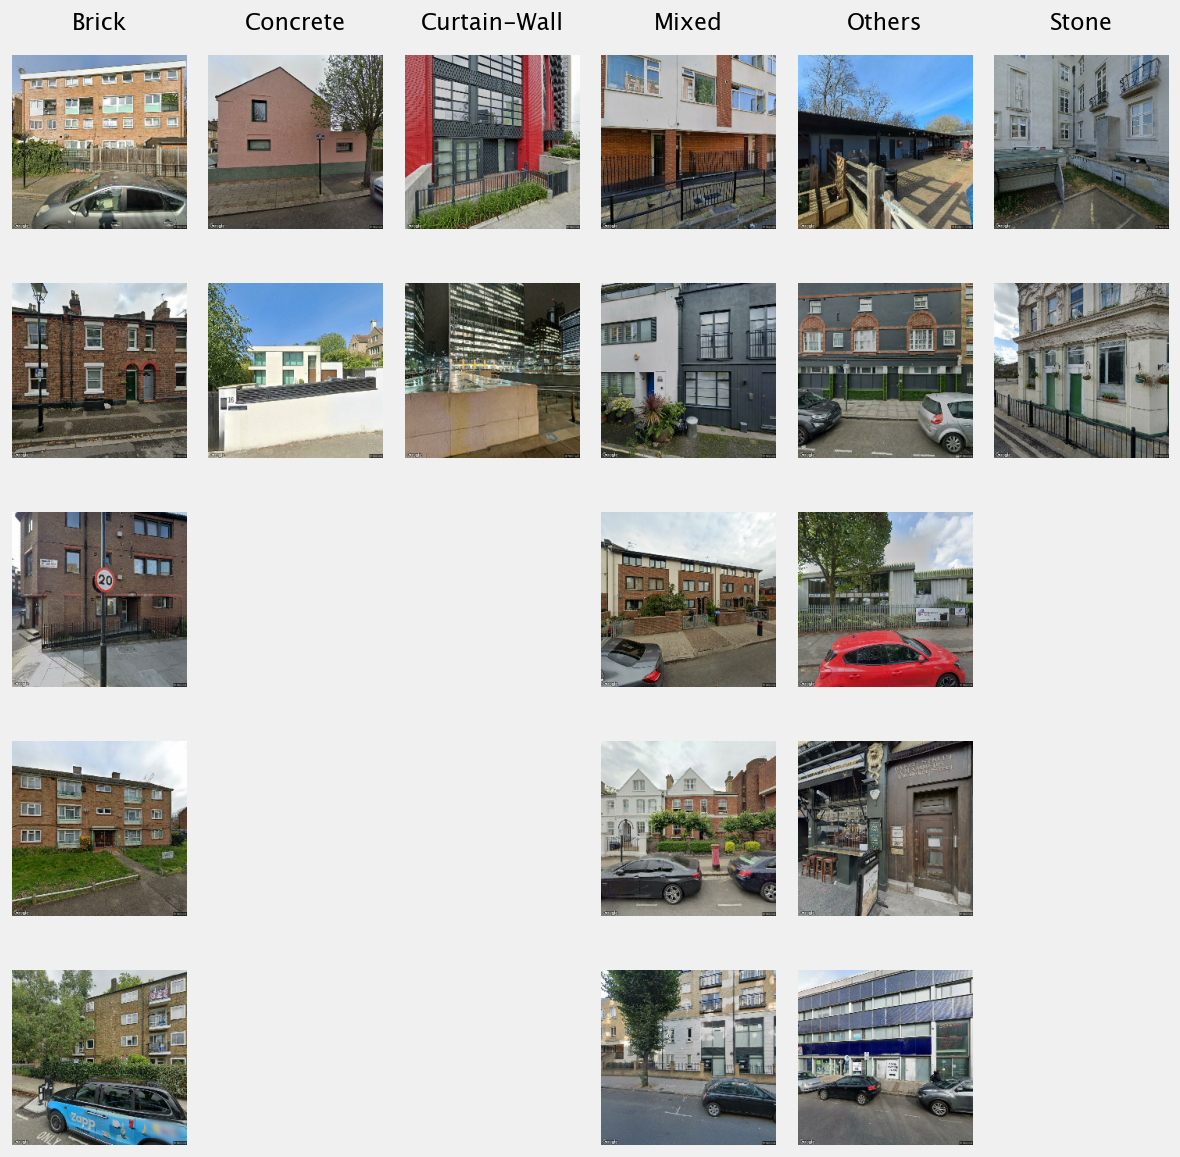

In [8]:
class_images = {class_name: [] for class_name in class_names}

for images, labels in train_ds_res.take(1):  # Take one batch of data
    for img, label in zip(images, labels):
        class_idx = tf.argmax(label).numpy()
        class_name = class_names[class_idx]
        if len(class_images[class_name]) < 5:  # Limit to 5 images per class
            class_images[class_name].append(img.numpy())

# visualize sample images of each class
plt.figure(figsize=(10, 10))
for class_idx, (class_name, imgs) in enumerate(class_images.items()):
    for img_idx, img in enumerate(imgs):
        ax = plt.subplot(5, len(class_names), img_idx * len(class_names) + class_idx + 1)
        plt.imshow(img.astype("uint8"))
        if img_idx == 0:
            plt.title(f"{class_name}", fontweight='bold')
        plt.axis("off")  
plt.tight_layout()
plt.show()

In [9]:
# opt prefetching, determine the best buffer size depending the hardware
AUTOTUNE = tf.data.AUTOTUNE
train_ds_res = train_ds_res.prefetch(buffer_size=AUTOTUNE)
val_ds_res = val_ds_res.prefetch(buffer_size=AUTOTUNE)

## Model (ResNet50)

In [11]:
# load ResNet50 base model
base_model = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # freeze base model

# build top classifier
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) # regularization added to prevent overfitting
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_res = models.Model(inputs, outputs)

model_res.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_res.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,758 (90.98 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### ResNet50 Training (London)

In [12]:
# optional: save the best model
checkpoint_cb = ModelCheckpoint("resnet_cladding_model.keras", save_best_only=True)

# optional: stop if validation accuracy doesn't improve for 3 epochs
earlystop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history_res = None
model_path_res = 'resnet_cladding_model.keras'
if os.path.exists(model_path_res):
    model_res = load_model('resnet_cladding_model.keras')
    print("Loaded existing model -> resnet_cladding_model.keras")
else:
    print("No existing model found, starting training from scratch.")
    history_res = model_res.fit(
        train_ds_res,
        validation_data=val_ds_res,
        epochs=20,
        callbacks=[earlystop_cb, checkpoint_cb]
    )

Loaded existing model -> resnet_cladding_model.keras


In [13]:
if history_res:
    acc = history_res.history['accuracy']
    val_acc = history_res.history['val_accuracy']
    loss = history_res.history['loss']
    val_loss = history_res.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, [a * 100 for a in acc], label='Train Accuracy', linewidth=2)
    plt.plot(epochs_range, [va * 100 for va in val_acc], label='Val Accuracy', linewidth=2)
    plt.title('Model Accuracy over Epochs (ResNet50)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.yticks(range(0, 101, 10))
    plt.ylim([0, 100]) 

    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Val Loss', linewidth=2)
    plt.title('Training and Validation Loss (ResNet50)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No training history available, skipping accuracy/loss plot.")

No training history available, skipping accuracy/loss plot.


### ResNet50 Test (London)

In [14]:
test_ds_res = tf.keras.utils.image_dataset_from_directory(
    test_path_lon,
    image_size=IMG_SIZE_RES,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_ds_res = test_ds_res.prefetch(tf.data.AUTOTUNE)

Found 314 files belonging to 6 classes.


In [15]:
loss_res, acc_res = model_res.evaluate(test_ds_res)
print(f"Test accuracy: {acc_res:.2%}")

2025-04-13 14:15:45.922765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.6934 - loss: 0.9943
Test accuracy: 63.38%


In [ ]:
y_true = np.concatenate([y.numpy() for x, y in test_ds_res])
y_pred_probs = model_res.predict(test_ds_res)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

print(classification_report(y_true_labels, y_pred, target_names=class_names))

cm = confusion_matrix(y_true_labels, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Proportion'})
plt.title("ResNet50 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()

# Model (Inception V3)

Build transfer learning model (Inception V3)

In [17]:
IMG_SIZE_INCEP = (299, 299)
BATCH_SIZE = 32

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model.trainable = False  # freeze convolutional base

inputs = Input(shape=(299, 299, 3))
x = preprocess_input(inputs)  # preprocess according to InceptionV3
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model_incep = Model(inputs, outputs)
model_incep.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_incep.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,830 (84.17 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [18]:
train_ds_incep = tf.keras.utils.image_dataset_from_directory(
    train_path_lon,
    image_size=IMG_SIZE_INCEP,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds_incep = tf.keras.utils.image_dataset_from_directory(
    val_path_lon,
    image_size=IMG_SIZE_INCEP,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 928 files belonging to 6 classes.
Found 308 files belonging to 6 classes.


### Inception V3 Training (London)

In [19]:
checkpoint_cb_incep = ModelCheckpoint("inception_cladding_model.keras", save_best_only=True)

earlystop_cb_incep = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_incep = None
model_path_incep = 'inception_cladding_model.keras'
if os.path.exists(model_path_incep):
    model_incep = load_model('inception_cladding_model.keras')
    print("Loaded existing model -> inception_cladding_model.keras")
else:
    print("No existing model found, starting training from scratch.")
    history_incep = model_incep.fit(
        train_ds_incep,
        validation_data=val_ds_incep,
        epochs=35,
        callbacks=[checkpoint_cb_incep]
    )

No existing model found, starting training from scratch.
Epoch 1/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 474ms/step - accuracy: 0.2837 - loss: 2.9284 - val_accuracy: 0.4740 - val_loss: 1.4638
Epoch 2/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - accuracy: 0.3655 - loss: 2.7819 - val_accuracy: 0.5682 - val_loss: 1.2998
Epoch 3/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 382ms/step - accuracy: 0.3483 - loss: 2.9628 - val_accuracy: 0.4870 - val_loss: 1.3725
Epoch 4/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.4006 - loss: 2.6419 - val_accuracy: 0.5779 - val_loss: 1.1728
Epoch 5/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.4292 - loss: 2.3508 - val_accuracy: 0.5519 - val_loss: 1.2641
Epoch 6/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.4778 - loss: 2.1260 - val_accuracy: 0.5877 - val_loss: 1.2763
Epoch 7/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.4897 - loss: 1.9637 - val_accuracy: 0.6558 - val_loss: 0.9759
Epoch 8/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 10

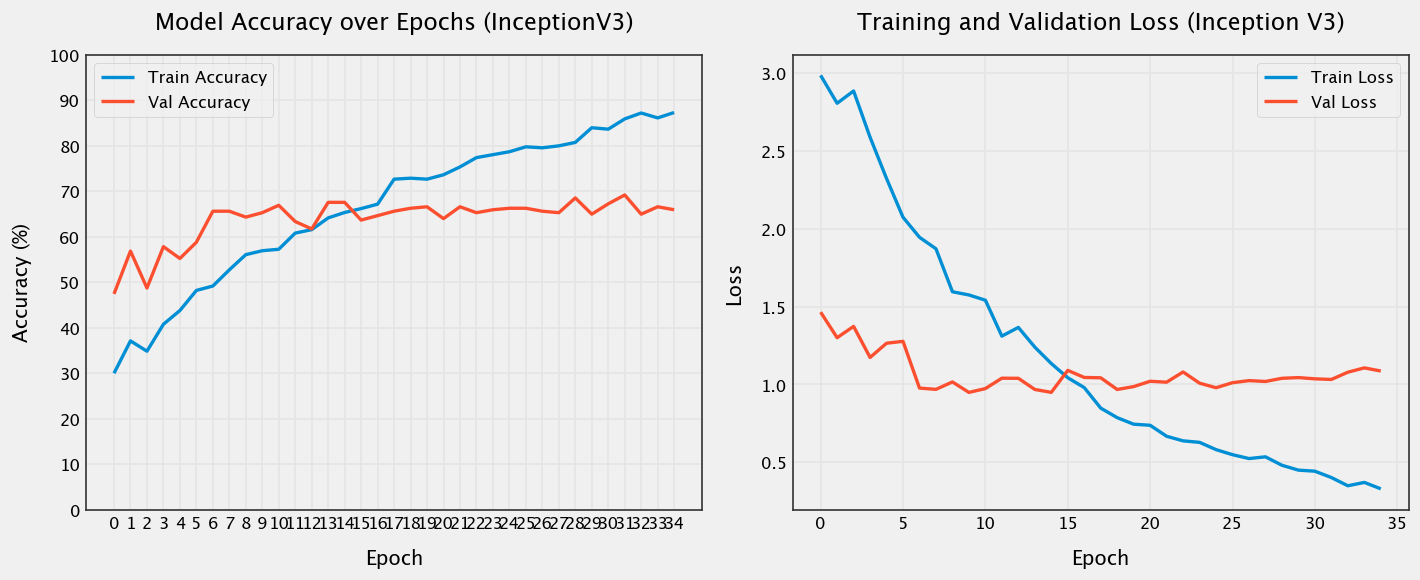

In [20]:
if history_incep:
    acc = history_incep.history['accuracy']
    val_acc = history_incep.history['val_accuracy']
    loss = history_incep.history['loss']
    val_loss = history_incep.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, [a * 100 for a in acc], label='Train Accuracy', linewidth=2)
    plt.plot(epochs_range, [va * 100 for va in val_acc], label='Val Accuracy', linewidth=2)
    plt.title('Model Accuracy over Epochs (InceptionV3)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.yticks(range(0, 101, 10))
    plt.ylim([0, 100]) 
    plt.xticks(epochs_range, [int(i) for i in epochs_range])  # Use integer ticks
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Val Loss', linewidth=2)
    plt.title('Training and Validation Loss (Inception V3)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No training history available, skipping accuracy/loss plot.")

### Inception V3 Test (London)

In [21]:
test_ds_incep = tf.keras.utils.image_dataset_from_directory(
    test_path_lon,
    image_size=IMG_SIZE_INCEP,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_ds_incep = test_ds_incep.prefetch(tf.data.AUTOTUNE)

Found 314 files belonging to 6 classes.


In [22]:
loss_incep, acc_incep = model_incep.evaluate(test_ds_incep)
print(f"Test Accuracy: {acc_incep:.2%}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - accuracy: 0.7443 - loss: 0.7447
Test Accuracy: 66.56%


2025-04-13 14:22:11.345070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 480ms/step
              precision    recall  f1-score   support

       Brick       0.88      0.87      0.87        89
    Concrete       0.54      0.53      0.54        47
Curtain-Wall       0.58      0.47      0.52        15
       Mixed       0.66      0.66      0.66       120
      Others       0.42      0.56      0.48        34
       Stone       0.50      0.22      0.31         9

    accuracy                           0.67       314
   macro avg       0.60      0.55      0.56       314
weighted avg       0.67      0.67      0.67       314



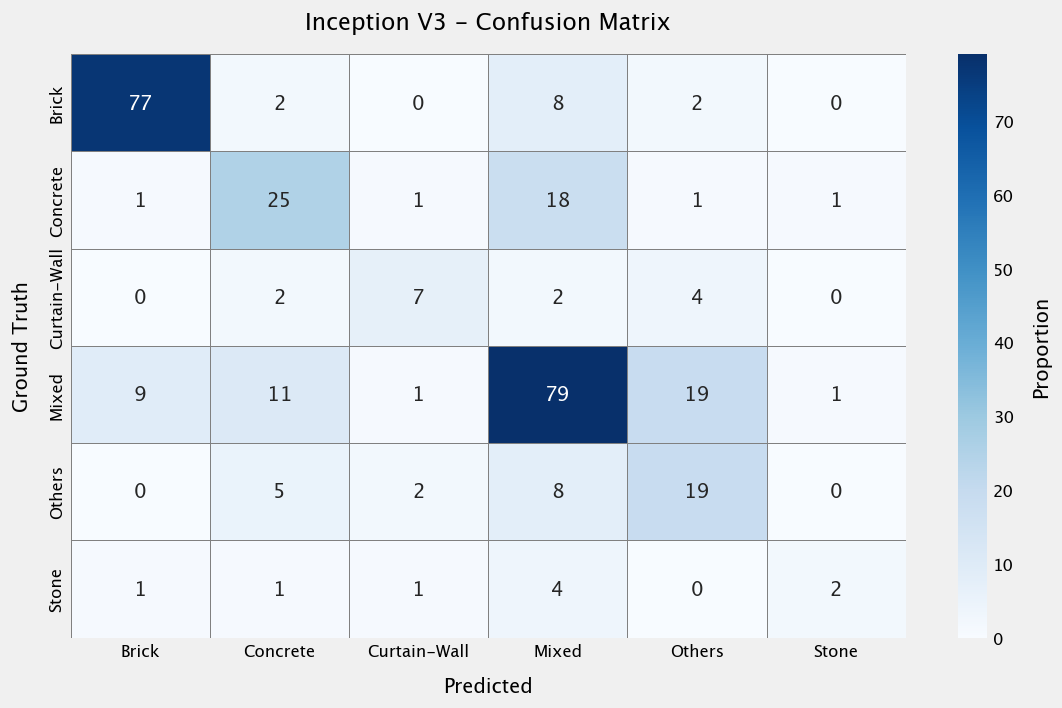

In [23]:
y_true = np.concatenate([y.numpy() for x, y in test_ds_incep])
y_pred_probs = model_incep.predict(test_ds_incep)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

print(classification_report(y_true_labels, y_pred, target_names=class_names))

cm = confusion_matrix(y_true_labels, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Proportion'})
plt.title("Inception V3 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()